#### Alexei Alves de Souza   Matrícula : 398611
#### UFC Mineração de Dados
#### Trabalho 3 -> Kmeans

# <p style="text-align: center;">Clusterização e algoritmo K-means</p> 

Organizar dados em agrupamentos é um dos modos fundamentais de compreensão e aprendizado. Como por exemplo, os organismos em um sistema biológico são classificados em domínio, reino, filo, classe, etc. A análise de agrupamento é o estudo formal de métodos e algoritmos para agrupar objetos de acordo com medidas ou características semelhantes. A análise de cluster, em sua essência, não utiliza rótulos de categoria que marcam objetos com identificadores anteriores, ou seja, rótulos de classe. A ausência de informação de categoria distingue o agrupamento de dados (aprendizagem não supervisionada) da classificação ou análise discriminante (aprendizagem supervisionada). O objetivo da clusterização é encontrar estruturas em dados e, portanto, é de natureza exploratória. 

A técnica de Clustering tem uma longa e rica história em uma variedade de campos científicos. Um dos algoritmos de clusterização mais populares e simples, o K-means, foi publicado pela primeira vez em 1955. Apesar do K-means ter sido proposto há mais de 50 anos e milhares de algoritmos de clustering terem sido publicados desde então, o K-means é ainda amplamente utilizado.

Fonte: Anil K. Jain, Data clustering: 50 years beyond K-means, Pattern Recognition Letters, Volume 31, Issue 8, 2010

# Objetivo

- Implementar as funções do algoritmo KMeans passo-a-passo
- Comparar a implementação com o algoritmo do Scikit-Learn
- Entender e codificar o Método do Cotovelo
- Utilizar o K-means em um dataset real 

# Carregando os dados de teste

Carregue os dados disponibilizados, e identifique visualmente em quantos grupos os dados parecem estar distribuídos.

In [1]:
# import libraries

# linear algebra
import numpy as np 
# data processing
import pandas as pd 
# data visualization
from matplotlib import pyplot as plt 

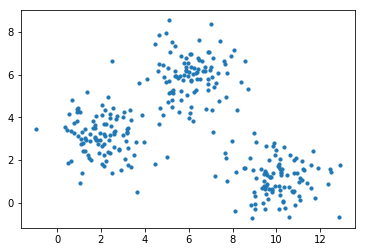

In [2]:
# load the data with pandas
dataset = pd.read_csv('dataset.csv', header=None)
dataset = np.array(dataset)

plt.scatter(dataset[:,0], dataset[:,1], s=10)
plt.show()

# 1. Implementar o algoritmo K-means

Nesta etapa você irá implementar as funções que compõe o algoritmo do KMeans uma a uma. É importante entender e ler a documentação de cada função, principalmente as dimensões dos dados esperados na saída.

## 1.1 Inicializar os centróides

A primeira etapa do algoritmo consiste em inicializar os centróides de maneira aleatória. Essa etapa é uma das mais importantes do algoritmo e uma boa inicialização pode diminuir bastante o tempo de convergência.

Para inicializar os centróides você pode considerar o conhecimento prévio sobre os dados, mesmo sem saber a quantidade de grupos ou sua distribuição. 

> Dica: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html 

#### A função de inicialização dos centróides é de extrema importância para a convergência em que dependendo da função e do dataset utilizado os dados podem não convergir.
#### O problema acima ocorreu ao utilizar da função apresentada em aula, a qual apenas inicializava de forma aleatória os centróides de acordo com o mínimo e máximo, o que não funcionava corretamente em distribuições de dados mais alongadas e pouco concentradas.
#### Para isso implementei a função a seguir que funciona da seguinte maneira:
#### -> ordena o dataset pela Norma do seu vetor
#### -> divide o dataset em partes iguais de acordo com o número de clusters estabelecidos
#### -> escolhe um centróide aleatória correspondente a um elemento do sub-dataset da iteração

In [3]:
### Calcula a norma de um vetor
def key_function(item):
    return np.sqrt(np.sum(np.square(item)))

In [4]:
def calculate_initial_centers(dataset, k):
    """
    Inicializa os centróides iniciais de maneira arbitrária 
    
    Argumentos:
    dataset -- Conjunto de dados - [m,n]
    k -- Número de centróides desejados
    
    Retornos:
    centroids -- Lista com os centróides calculados - [k,n]
    
    """
    st = 0
    end = len(dataset)
    centroids = np.empty(0)
    rand_gen = np.random.default_rng()
    
    #Ordena o dataset pela Norma do vetor
    dataset = dataset.tolist()
    dataset = sorted(dataset,key = key_function)
    dataset = np.array(dataset)
    
    for i in range (k):
        
            if i == k-1:
                idx = end 
            else:
                idx =(end//k)*(i+1)
            aux_data = dataset[st:idx]
            st = idx
            ctd = rand_gen.choice(aux_data,1)
            centroids = np.append(centroids,ctd)
    
    
    centroids = centroids.reshape(k,dataset.shape[1])
    return centroids

Teste a função criada e visualize os centróides que foram calculados.

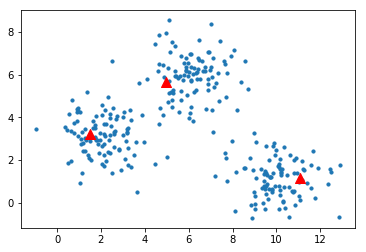

In [5]:
k = 3
centroids = calculate_initial_centers(dataset, k)

plt.scatter(dataset[:,0], dataset[:,1], s=10)
plt.scatter(centroids[:,0], centroids[:,1], marker='^', c='red',s=100)
plt.show()

## 1.2 Definir os clusters

Na segunda etapa do algoritmo serão definidos o grupo de cada dado, de acordo com os centróides calculados.

### 1.2.1 Função de distância 

Codifique a função de distância euclidiana entre dois pontos __(a, b)__.

Definido pela equação:

$$ dist(a, b) = \sqrt{(a_1-b_1)^{2}+(a_2-b_2)^{2}+ ... + (a_n-b_n)^{2}} $$

$$ dist(a, b) = \sqrt{\sum_{i=1}^{n}(a_i-b_i)^{2}} $$

#### Para a função de distância optei por utilizar a distância euclidiana, a qual foi também apresentada em classe

In [6]:
def euclidean_distance(a, b):
    """
    Calcula a distância euclidiana entre os pontos a e b
    
    Argumentos:
    a -- Um ponto no espaço - [1,n]
    b -- Um ponto no espaço - [1,n]
    
    Retornos:
    distance -- Distância euclidiana entre os pontos
    """
    distance = np.sqrt(np.sum(np.square(a-b)))
    
    return distance

Teste a função criada.

In [7]:
a = np.array([1, 5, 9])
b = np.array([3, 7, 8])

if (euclidean_distance(a,b) == 3):
    print("Distância calculada corretamente!")
else:
    print("Função de distância incorreta")

Distância calculada corretamente!


### 1.2.2 Calcular o centroide mais próximo

Utilizando a função de distância codificada anteriormente, complete a função abaixo para calcular o centroid mais próximo de um ponto qualquer. 

> Dica: https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html

#### Essa função basicamente calcula a distância do ponto desejada em relação a cada centróide e retorna o índice do centróide que apresentou a menor distância.

In [8]:
def nearest_centroid(a, centroids):
    """
    Calcula o índice do centroid mais próximo ao ponto a
    
    Argumentos:
    a -- Um ponto no espaço - [1,n]
    centroids -- Lista com os centróides - [k,n]
    
    Retornos:
    nearest_index -- Índice do centróide mais próximo
    """
    #Inicializa a distância com o valor inifinito ou maior valor possível em bytes admitido pelo python.
    dist = float('inf')
    
    for idx,i in enumerate (centroids):
        aux = euclidean_distance(a,i)
        if  aux < dist :
            dist = aux
            nearest_index = idx
    
    
    return nearest_index

Teste a função criada

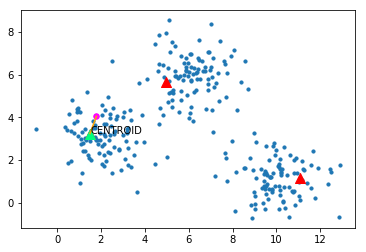

In [9]:
# Seleciona um ponto aleatório no dataset
index = np.random.randint(dataset.shape[0])
a = dataset[index,:]

# Usa a função para descobrir o centroid mais próximo
idx_nearest_centroid = nearest_centroid(a, centroids)


# Plota os dados ------------------------------------------------
plt.scatter(dataset[:,0], dataset[:,1], s=10)
# Plota o ponto aleatório escolhido em uma cor diferente
plt.scatter(a[0], a[1], c='magenta', s=30)

# Plota os centroids
plt.scatter(centroids[:,0], centroids[:,1], marker='^', c='red', s=100)
# Plota o centroid mais próximo com uma cor diferente
plt.scatter(centroids[idx_nearest_centroid,0], 
            centroids[idx_nearest_centroid,1],
            marker='^', c='springgreen', s=100)

# Cria uma linha do ponto escolhido para o centroid selecionado
plt.plot([a[0], centroids[idx_nearest_centroid,0]], 
         [a[1], centroids[idx_nearest_centroid,1]],c='orange')
plt.annotate('CENTROID', (centroids[idx_nearest_centroid,0], 
            centroids[idx_nearest_centroid,1],))
plt.show()

### 1.2.3 Calcular centroid mais próximo de cada dado do dataset

Utilizando a função anterior que retorna o índice do centroid mais próximo, calcule o centroid mais próximo de cada dado do dataset. 

In [10]:
def all_nearest_centroids(dataset, centroids):
    """
    Calcula o índice do centroid mais próximo para cada 
    ponto do dataset
    
    Argumentos:
    dataset -- Conjunto de dados - [m,n]
    centroids -- Lista com os centróides - [k,n]
    
    Retornos:
    nearest_indexes -- Índices do centróides mais próximos - [m,1]
    """
    nearest_indexes = np.zeros((dataset.shape[0]),dtype = int)
    for idx,i in enumerate (dataset):
        nearest_idx = nearest_centroid(i,centroids)
        nearest_indexes[idx] = nearest_idx
    
    
    return nearest_indexes

Teste a função criada visualizando os cluster formados.

In [11]:
nearest_indexes = all_nearest_centroids(dataset, centroids)

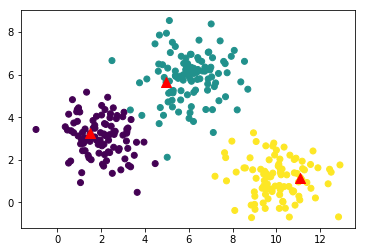

In [12]:
plt.scatter(dataset[:,0], dataset[:,1], c=nearest_indexes)
plt.scatter(centroids[:,0], centroids[:,1], marker='^', c='red', s=100)
plt.show()

## 1.3 Métrica de avaliação 

Após formar os clusters, como sabemos se o resultado gerado é bom? Para isso, precisamos definir uma métrica de avaliação.

O algoritmo K-means tem como objetivo escolher centróides que minimizem a soma quadrática das distância entre os dados de um cluster e seu centróide. Essa métrica é conhecida como __inertia__.

$$\sum_{i=0}^{n}\min_{c_j \in C}(||x_i - c_j||^2)$$

A __inertia__, ou o critério de soma dos quadrados dentro do cluster, pode ser reconhecido como uma medida de o quão internamente coerentes são os clusters, porém ela sofre de alguns inconvenientes:

- A inertia pressupõe que os clusters são convexos e isotrópicos, o que nem sempre é o caso. Desta forma, pode não representar bem em aglomerados alongados ou variedades com formas irregulares.
- A inertia não é uma métrica normalizada: sabemos apenas que valores mais baixos são melhores e zero é o valor ótimo. Mas em espaços de dimensões muito altas, as distâncias euclidianas tendem a se tornar infladas (este é um exemplo da chamada “maldição da dimensionalidade”). A execução de um algoritmo de redução de dimensionalidade, como o PCA, pode aliviar esse problema e acelerar os cálculos.

Fonte: https://scikit-learn.org/stable/modules/clustering.html

Para podermos avaliar os nosso clusters, codifique a métrica da inertia abaixo, para isso você pode utilizar a função de distância euclidiana construída anteriormente.

$$inertia = \sum_{i=0}^{n}\min_{c_j \in C} (dist(x_i, c_j))^2$$

In [13]:
def inertia(dataset, centroids, nearest_indexes):
    """
    Soma das distâncias quadradas das amostras para o 
    centro do cluster mais próximo.
    
    Argumentos:
    dataset -- Conjunto de dados - [m,n]
    centroids -- Lista com os centróides - [k,n]
    nearest_indexes -- Índices do centróides mais próximos - [m,1]
    
    Retornos:
    inertia -- Soma total do quadrado da distância entre 
    os dados de um cluster e seu centróide
    """
    inertia = 0
    for idx,i in enumerate (dataset):
        inertia += np.square(euclidean_distance(i,centroids[nearest_indexes[idx]]))
    
    return inertia

Teste a função codificada executando o código abaixo.

In [14]:
tmp_data = np.array([[1,2,3],[3,6,5],[4,5,6]])
tmp_centroide = np.array([[2,3,4]])

tmp_nearest_indexes = all_nearest_centroids(tmp_data, tmp_centroide)
test_inertia = inertia(tmp_data, tmp_centroide, tmp_nearest_indexes)
if test_inertia == 26:
    print(test_inertia,"Inertia calculada corretamente!")
else:
    print(test_inertia,"Função de inertia incorreta!")

26.0 Inertia calculada corretamente!


In [15]:
# Use a função para verificar a inertia dos seus clusters
inertia(dataset, centroids, nearest_indexes)

888.6644547604569

## 1.4 Atualizar os clusters

Nessa etapa, os centróides são recomputados. O novo valor de cada centróide será a media de todos os dados atribuídos ao cluster.

In [16]:
def update_centroids(dataset, centroids, nearest_indexes):
    """
    Atualiza os centroids
    
    Argumentos:
    dataset -- Conjunto de dados - [m,n]
    centroids -- Lista com os centróides - [k,n]
    nearest_indexes -- Índices do centróides mais próximos - [m,1]
    
    Retornos:
    centroids -- Lista com centróides atualizados - [k,n]
    """
    
    for idx in range (len(centroids)):
        indices, = np.where(nearest_indexes == idx)
        data = dataset[indices]
        centroid = np.vstack((data,centroids[idx]))
        centroid = np.mean(centroid,axis = 0)
        centroids[idx] = centroid
        
    return centroids

Visualize os clusters formados

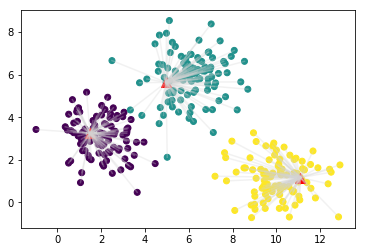

In [17]:
nearest_indexes = all_nearest_centroids(dataset, centroids)

# Plota os os cluster ------------------------------------------------
plt.scatter(dataset[:,0], dataset[:,1], c=nearest_indexes)

# Plota os centroids
plt.scatter(centroids[:,0], centroids[:,1], marker='^', c='red', s=100)
for index, centroid in enumerate(centroids):
    dataframe = dataset[nearest_indexes == index,:]
    for data in dataframe:
        plt.plot([centroid[0], data[0]], [centroid[1], data[1]], 
                 c='lightgray', alpha=0.3)
plt.show()

Execute a função de atualização e visualize novamente os cluster formados

In [18]:
centroids = update_centroids(dataset, centroids, nearest_indexes)

# 2. K-means

## 2.1 Algoritmo completo

Utilizando as funções codificadas anteriormente, complete a classe do algoritmo K-means!

#### Aqui é apresentado o algoritimo Kmeans completo com duas funções :
### fit:
#### -> Atualiza os centróides até o número máximo de iterações ou se o valor de inertia permancer inalterado entre duas iterações
### predict:
#### -> Faz a predição de a qual cluster pertence um ponto ou conjunto de pontos arbitrários especificados retornando o índice dos centroides.

In [19]:
class KMeans():
    
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    
    def fit(self,X):
        X = np.array(X)
        # Inicializa os centróides
        self.cluster_centers_ = calculate_initial_centers(X,self.n_clusters)
        
        # Computa o cluster de cada amostra
        self.labels_ = all_nearest_centroids(X,self.cluster_centers_)
        
        # Calcula a inércia inicial
        old_inertia = inertia(X,self.cluster_centers_,self.labels_)
        
        self.inertia_ = old_inertia
        
        for index in range (self.max_iter):
                old_inertia = self.inertia_
                self.cluster_centers_ = update_centroids(X,self.cluster_centers_,self.labels_)
                self.labels_ = all_nearest_centroids(X,self.cluster_centers_)
                self.inertia_ = inertia(X,self.cluster_centers_,self.labels_)
               
            
                if old_inertia == self.inertia_:
                    break
                
                    
        return self
    
    def predict(self, X):
        X = np.array(X)
        nearest_centroids = all_nearest_centroids(X,self.cluster_centers_)
        
        return nearest_centroids

Verifique o resultado do algoritmo abaixo!

Inércia =  608.6035508327778


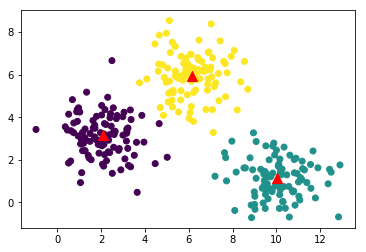

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(dataset)

print("Inércia = ", kmeans.inertia_)

plt.scatter(dataset[:,0], dataset[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

In [21]:
print('Centroides:\n',kmeans.cluster_centers_)

Centroides:
 [[ 2.08059639  3.14281045]
 [10.03081014  1.12728525]
 [ 6.15412257  5.94592545]]


## 2.2 Comparar com algoritmo do Scikit-Learn

Use a implementação do algoritmo do scikit-learn do K-means para o mesmo conjunto de dados. Mostre o valor da inércia  e os conjuntos gerados pelo modelo. Você pode usar a mesma estrutura da célula de código anterior.
> Dica: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans

#### Como esperado o algoritimo Kmeans do sklearn forneceu o resultado tanto gráfico como o valor de inércia

Inércia =  608.6035508327782


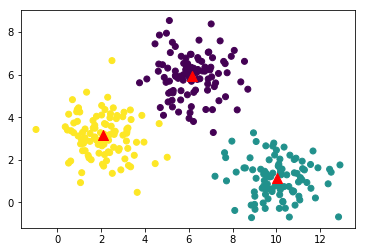

In [22]:
from sklearn.cluster import KMeans as sklearn_KMeans
import numpy as np

X = np.copy(dataset)
kmeans = sklearn_KMeans(n_clusters=3, random_state=0).fit(X)

print("Inércia = ", kmeans.inertia_)

plt.scatter(dataset[:,0], dataset[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

In [23]:
print('Centroides:\n', kmeans.cluster_centers_)

Centroides:
 [[ 6.15412257  5.94592545]
 [10.03081014  1.12728525]
 [ 2.08059639  3.14281045]]


# 3. Método do cotovelo

Implemete o método do cotovelo e mostre o melhor K para o conjunto de dados.

#### O método do cotovelo calcula o valor de inércia para um determinado número mínimo e máximo de clusters especificados e estabelece que aquele cujo ponto e a distância entre a reta que completa o polígono obtido for maior é o número de clusters ideal.
#### Aqui é mostrado um plot para o método do cotovelo para os valores de 2 à 10 centróides.

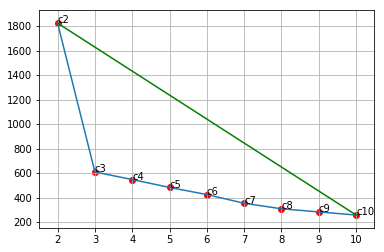

In [24]:
n_max = 10
tam = n_max - 1

inertias = np.zeros(tam)
clusters = np.arange(2,n_max+1)
labels = np.char.add(['c']*tam,clusters.astype(str))

for i in range (2,n_max+1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(dataset)
    
    inertias[i-2] = kmeans.inertia_

plt.plot(clusters,inertias)
plt.plot([clusters[0],clusters[tam-1]], [inertias[0],inertias[tam-1]],c = 'green')
    
plt.scatter(clusters,inertias, c = 'red')
for i,txt in enumerate (labels):
    plt.annotate(txt,(clusters[i],inertias[i]))

plt.grid()
plt.show()

In [25]:
### Função da distância de um ponto a reta
def distance_point_to_line(p,lp1,lp2):
    
    num = abs((lp2[1]-lp1[1])*p[0] - (lp2[0]-lp1[0])*p[1] + lp2[0]*lp1[1]  - lp2[1]*lp1[0])
    den = np.sqrt(np.sum(np.square(lp2-lp1)))
    distance = num/den
    
    return distance
    

In [26]:
### Função que implementa o método do cotovelo
def elbow_method(max_clusters,dataset):
    tam = max_clusters - 1
    
    inertias = np.zeros(tam)
    clusters = np.arange(2,max_clusters+1)
    
    
    #Calcula as inertias
    for i in range (2,max_clusters+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(dataset)
    
        inertias[i-2] = kmeans.inertia_    
    
    #Calcula as distancias à reta
    lp1 = np.array([2,inertias[0]])
    lp2 = np.array([max_clusters,inertias[tam-1]])
    
    distances = np.zeros(tam)
    
    for i in range (tam):
        p = np.array([clusters[i],inertias[i]])
        distances[i] = distance_point_to_line(p,lp1,lp2)
    
    return np.argmax(distances)+2
    

    

# 4. Dataset Real

Exercícios

1 - Aplique o algoritmo do K-means desenvolvido por você no datatse iris [1]. Mostre os resultados obtidos utilizando pelo menos duas métricas de avaliação de clusteres [2].

- [1] http://archive.ics.uci.edu/ml/datasets/iris
- [2] http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

> Dica: você pode utilizar as métricas completeness e homogeneity.

2 - Tente melhorar o resultado obtido na questão anterior utilizando uma técnica de mineração de dados. Explique a diferença obtida. 

> Dica: você pode tentar normalizar os dados [3].
> - [3] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html


3 - Qual o número de clusteres (K) você escolheu na questão anterior? Desenvolva o Método do Cotovelo sem usar biblioteca e descubra o valor de K mais adequado. Após descobrir, utilize o valor obtido no algoritmo do K-means.

4 - Utilizando os resultados da questão anterior, refaça o cálculo das métricas e comente os resultados obtidos. Houve uma melhoria? Explique.

###### 4.1 Aplicando Kmeans no iris dataset

In [27]:
from sklearn import datasets

In [28]:
iris_dataset = datasets.load_iris()
iris_data = iris_dataset.data
iris_labels = iris_dataset.target

In [29]:
iris_dataset.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

#### Aqui o K-means desenvolvido é aplicado no iris dataset para 4 clusters , 1 mais que o valor de classes já conhecido.

Inércia =  57.25600931571819


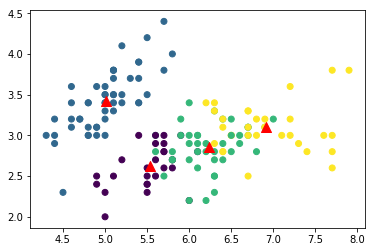

In [31]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(iris_data)

print("Inércia = ", kmeans.inertia_)

plt.scatter(iris_data[:,0], iris_data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

##### 4.1 -> Métricas de Avaliação
##### homogeneity: Cada cluster contém elementos de somente uma classe
##### completeness: Os membros de uma classe estão todos contidos no mesmo cluster

#### obs : os valores de homogeneidade e completude vão de 0 -> 1 

In [32]:
from sklearn import metrics

In [33]:
metrics.homogeneity_score(iris_labels,kmeans.labels_)

0.8052353762882726

In [34]:
metrics.completeness_score(iris_labels,kmeans.labels_)

0.650961349654246

##### 4.2

In [35]:
from sklearn.preprocessing import normalize

#### É realizada a normalização em cada coluna pois os valores de diferentes dimensões podem ter unidades diferentes

In [36]:
x = iris_data[:,0]
x = x.reshape(1,150)
x = normalize(x)
x = x.reshape(150)

y = iris_data[:,1]
y = y.reshape(1,150)
y = normalize(y)
y = y.reshape(150)

z = iris_data[:,2]
z = z.reshape(1,150)
z = normalize(z)
z = z.reshape(150)

w = iris_data[:,3]
w = w.reshape(1,150)
w = normalize(w)
w = w.reshape(150)

norm_iris_data = np.array(list(zip(x,y,z,w)))

Inércia =  0.0347100844924716


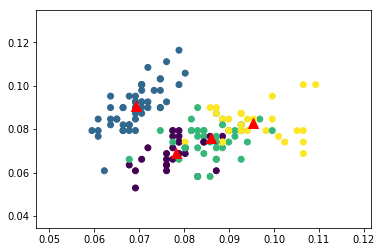

In [37]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(norm_iris_data)

print("Inércia = ", kmeans.inertia_)

###Plot dos valores da largura e comprimento das sépalas
plt.scatter(norm_iris_data[:,0], norm_iris_data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

In [38]:
metrics.homogeneity_score(iris_labels,kmeans.labels_)

0.823628743141193

In [39]:
metrics.completeness_score(iris_labels,kmeans.labels_)

0.6663936034315758

#### Observamos que os grau de homogeneidade e completude o que era esperado pela aproximação dos dados dispersos de seus respectivos clusters.

###### 4.3 -> Método do Cotovelo

In [40]:
k = elbow_method(10,norm_iris_data)
k

3

##### 4.4 -> Aplicação com o k obtido pelo elbow_method

Inércia =  0.046041954607066234


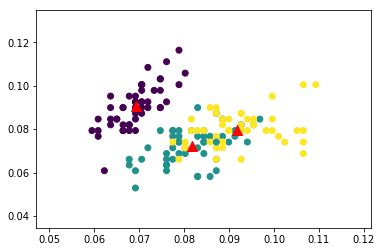

In [41]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(norm_iris_data)

print("Inércia = ", kmeans.inertia_)

plt.scatter(norm_iris_data[:,0], norm_iris_data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], marker='^', c='red', s=100)
plt.show()

#### Gráfico 3D dos atrbutos:
#### color = labels
#### quarta dimensão é observada pela pequena variação das cores nos clusters


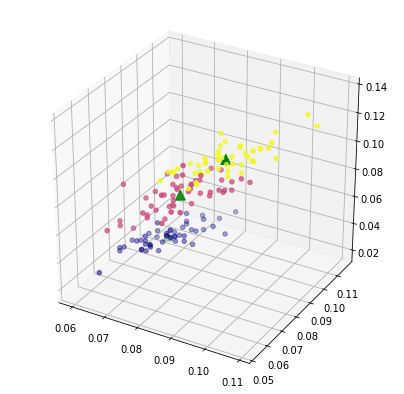

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(norm_iris_data[:,0], norm_iris_data[:,1],norm_iris_data[:,2], norm_iris_data[:,3],
                 c =kmeans.labels_,cmap='plasma')

img2 = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],
                  kmeans.cluster_centers_[:,2],kmeans.cluster_centers_[:,3],marker='^', c='green',cmap='plasma',s = 100)
plt.show()

In [44]:
metrics.homogeneity_score(iris_labels,kmeans.labels_)

0.8639756867013153

In [45]:
metrics.completeness_score(iris_labels,kmeans.labels_)

0.8643954288752763

#### Aplicando o método do cotovelo obtemos o número de 3 clusters que é o valor esperado, bem como observando as métricas concluímos que os clusters formados são bem mais homgêneos e completos após a normalização e escolha de um k adequado.

#### Conclusão:
##### A partir dessa atividade foi possível entender como os algoritimos de clustering funcionam e suas aplicações, além disso foi possível observar que dependendo do tipo de dataset pode ser necessário uma abordagem diferente das funções utilizadas.
##### No algoritimo desenvolvido nesta atividade ao se utilizar a distância euclidiana notou-se algumas discrepâncias com relações à convergências do algoritimo, as quais foram amenizadas por uma abordagem diferente de escolha dos centróides iniciais, porém longe de ser um resultado ideal.
#### Assim é possível concluir que foi muito proveitoso esse aprendizado e o mesmo servirá para análises e aperfeiçoamentos futuros dos conhecimentos adquiridos tanto de suas aplicaçãos quanto aos aspectos que devem ser tratados com cuidado baseados na complexidade de cada dataset.
